In [5]:
import os
import numpy as np
import tensorflow as tf
import itertools
import keras

from keras.datasets import cifar10 # cifar image set http://www.cs.toronto.edu/~kriz/cifar.html
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display # display our images
from keras.preprocessing.image import array_to_img

from keras.callbacks import TensorBoard # We'll use Tensorboard to track the performance of our model
from time import strftime # picks up the current system time

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/Users/chungleu@uk.ibm.com/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chungleu@uk.ibm.com/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chungleu@uk.ibm.com/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chungleu@uk.ibm.com/o

# Constants

In [6]:
# CIFAR image set has 10 different types of objects
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get Data

In [7]:
# From the cifar dataset, we determine our training and test datasets
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [8]:
x_train_all.shape

(50000, 32, 32, 3)

In [9]:
# This shows us how mane images are, its size in pixels, and how many colour channels each pixel can have
# Each pixel uses RGB, a description of the mix of Red, Green, and Blue to give its final colour

nr_image, x, y, c = x_train_all.shape
print(f'image = {nr_image} \t| width = {x} \t| height = {y} \t| channels = {c}')

image = 50000 	| width = 32 	| height = 32 	| channels = 3


# Explore Data

In [10]:
# Take a look at what our training data actually looks like
# As above, it'll be 50,000 images, each with 32x32 pixels with 3 values for RGB colours
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

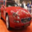

In [11]:
# Show the pic for the 6th image in our set
# You may need to squint for this bit
pic = array_to_img(x_train_all[5])
display(pic)

In [12]:
# What label is this?
y_train_all[5][0]

1

In [13]:
LABEL_NAMES[y_train_all[5][0]]

'Car'

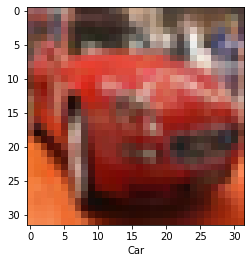

In [14]:
plt.imshow(x_train_all[5])
plt.xlabel(LABEL_NAMES[y_train_all[5][0]])
plt.show()

# PreProcess Data

In [15]:
# RGB colours are from 0-255
# We're going to scale our data down to values between 0 and 1
# This makes it easier for our model to process

In [16]:
x_train_all[0][0][0]

array([59, 62, 63], dtype=uint8)

In [17]:
x_train_all, x_test = x_train_all /255.0, x_test / 255.0

In [18]:
x_train_all[0][0][0]

array([0.23137255, 0.24313725, 0.24705882])

In [19]:
# Our dataset shape remains the same even though we've changed the values
x_train_all.shape

(50000, 32, 32, 3)

In [20]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOUR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOUR_CHANNELS
TOTAL_INPUTS

3072

In [21]:
# We're going to reshape our dataset, flattening it so it doesn't have so many nested dimensions
x_train_all = x_train_all.reshape(len(x_train_all), TOTAL_INPUTS)

In [22]:
x_train_all.shape

(50000, 3072)

In [23]:
# Each image is not flattened as one long array
x_train_all[0]

array([0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
       0.28235294])

In [24]:
# Do the same for our test set
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)

In [25]:
x_test.shape

(10000, 3072)

# Create Validation Dataset

In [26]:
# 1st 10,000 items
x_validate = x_train_all[0:VALIDATION_SIZE]
y_validate = y_train_all[0:VALIDATION_SIZE]
x_validate.shape

(10000, 3072)

In [27]:
# Everything from 10,001 onwards
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

## Create a demo small dataset

In [28]:
# We can use this later to quickly validate our model works

In [29]:
x_train_xs = x_train[0:SMALL_TRAIN_SIZE]
y_train_xs = y_train[0:SMALL_TRAIN_SIZE]

# Define our Keras Neural Network

For more theory on neural networks and their layers, check out this vid from an excellent Data Science youtuber:
https://www.youtube.com/watch?v=aircAruvnKk

In [30]:
# Keras lets us build networks with more straightforward code than TensorFlow (sacrificing some immediate granular control)
# We're going to build a simple 4 layer neural network
# 1 start layer, 2 hidden layers, condensing down to our output layer
model = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='input'), # Start layer
    Dense(units=64, activation='relu', name='hidden1'),    # Hidden layer 1
    Dense(units=16, activation='relu', name='hidden2'),    # Hidden layer 2
    Dense(units=10, activation='softmax', name='output')    # Output layer
])

In [31]:
model

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 128)               393344    
_________________________________________________________________
hidden1 (Dense)              (None, 64)                8256      
_________________________________________________________________
hidden2 (Dense)              (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


# Alternate Models (OPTIONAL)
These are optional variants for you to play around with if you like.
They demonstrate different techniques to tweak our model

### Alternate Model #1 with dropout in input layer

In [34]:
# Dropout at Input Layer
# Dropout randomly 'drops' neurons in the input layer
# The theory being that if random sections are missing from our input, more subtle relationships are acknowledged
# https://towardsdatascience.com/introduction-to-dropout-to-regularize-deep-neural-network-8e9d6b1d4386

In [35]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 3072)              0         
_________________________________________________________________
m2_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m2_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m2_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m2_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


### Alternate Model #2 with dropout in hidden layers

In [37]:
# Dropout at Hidden Layer + Input Layer

In [38]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(16, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 3072)              0         
_________________________________________________________________
m3_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
m3_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m3_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m3_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
________________________________________________

# Tensorboard
Tensorboard is a neat tool that lets us track the performance of our model over time.
It lets us see how the tweaks we make improve or degrade performance e.g. accuracy and over/underfitting

To make this work we should create a sibling folder called 'tensorboard_logs' in the same folder as this notebook

In [40]:
# We're creating a function that our model will use when it runs
# This function will create a new folder for the model when we run it
# The model will dump its logs in that reference folder

def get_tensorboard(model):
    folder_name = f'{model} at {strftime("%H %M %S")}'
    dir_paths = os.path.join('tensorboard_logs', folder_name)
    
    try:
        os.makedirs(dir_paths)
    except OSERROR as errr:
        print(err.sterror)
    else:
        print('Created log directory')
    
    return TensorBoard(log_dir=dir_paths)

To activate tensorboard locally, run the code below in your terminal or command prompt:

In [41]:
# tensorboard --logdir=<the filepath to your tensorboard log parent folder>

# e.g.
# tensorboard --logdir /Users/chungleu@uk.ibm.com/Documents/Projects/ ... ... /tensorboard_logs
# or
# tensorboard --logdir=/Users/chungleu@uk.ibm.com/Documents/Projects/ ... ... /tensorboard_logs

Running the above will show live performance logs. The terminal should tell you where it is hosted. <br>
The default location is http://localhost:6006 <br>
It won't show anything until the model is run though.

# Fit Our Model

In [42]:
# Try this with different models (1, 2, 3, or anything else you create)
# Tensorboard should automatically update with the performance of different models

In [43]:
# We'll use these constants to set our batch size (size of chunks to break up our training data into)
# and our epochs (number of times to iterate over the whole dataset)

SAMPLES_PER_BATCH = 1000
NR_EPOCHS = 100

In [53]:
%%time
# We're using time because this may take a while
# But we're setting verbose to 2 which means we'll see performance in the console
# https://keras.rstudio.com/reference/fit.html

model.fit(
# Un-comment one of the below to set which training and target data we want to use
    x = x_train_xs, y = y_train_xs,
#     x = x_train, y = y_train,
         validation_data = (x_validate, y_validate),
         batch_size = SAMPLES_PER_BATCH,
         epochs = NR_EPOCHS,
         callbacks=[get_tensorboard('model')],
         verbose=2
         )

Created log directory
Train on 1000 samples, validate on 10000 samples


Epoch 1/100
 - 0s - loss: 2.4255 - accuracy: 0.0990 - val_loss: 2.9515 - val_accuracy: 0.1025

Epoch 2/100
 - 0s - loss: 2.8915 - accuracy: 0.1140 - val_loss: 2.8701 - val_accuracy: 0.0974
Epoch 3/100
 - 0s - loss: 2.8758 - accuracy: 0.0990 - val_loss: 2.5142 - val_accuracy: 0.0974
Epoch 4/100
 - 0s - loss: 2.5112 - accuracy: 0.0990 - val_loss: 2.3606 - val_accuracy: 0.0903
Epoch 5/100
 - 0s - loss: 2.3377 - accuracy: 0.0850 - val_loss: 2.3427 - val_accuracy: 0.1066
Epoch 6/100
 - 0s - loss: 2.3135 - accuracy: 0.1170 - val_loss: 2.3478 - val_accuracy: 0.1018
Epoch 7/100
 - 0s - loss: 2.3146 - accuracy: 0.1170 - val_loss: 2.3376 - val_accuracy: 0.1112
Epoch 8/100
 - 0s - loss: 2.3085 - accuracy: 0.1290 - val_loss: 2.3265 - val_accuracy: 0.1160
Epoch 9/100
 - 0s - loss: 2.3020 - accuracy: 0.1220 - val_loss: 2.3117 - val_accuracy: 0.1450
Epoch 10/100
 - 0s - loss: 2.2882 - accuracy: 0.1440 - val_loss: 2.2980 - val_ac

Epoch 80/100
 - 0s - loss: 1.8771 - accuracy: 0.3600 - val_loss: 2.0381 - val_accuracy: 0.2758
Epoch 81/100
 - 0s - loss: 1.8710 - accuracy: 0.3700 - val_loss: 2.0357 - val_accuracy: 0.2727
Epoch 82/100
 - 0s - loss: 1.8644 - accuracy: 0.3710 - val_loss: 2.0339 - val_accuracy: 0.2730
Epoch 83/100
 - 0s - loss: 1.8581 - accuracy: 0.3640 - val_loss: 2.0326 - val_accuracy: 0.2739
Epoch 84/100
 - 0s - loss: 1.8524 - accuracy: 0.3740 - val_loss: 2.0312 - val_accuracy: 0.2701
Epoch 85/100
 - 0s - loss: 1.8478 - accuracy: 0.3650 - val_loss: 2.0340 - val_accuracy: 0.2734
Epoch 86/100
 - 0s - loss: 1.8456 - accuracy: 0.3840 - val_loss: 2.0371 - val_accuracy: 0.2663
Epoch 87/100
 - 0s - loss: 1.8469 - accuracy: 0.3550 - val_loss: 2.0350 - val_accuracy: 0.2703
Epoch 88/100
 - 0s - loss: 1.8388 - accuracy: 0.3880 - val_loss: 2.0255 - val_accuracy: 0.2700
Epoch 89/100
 - 0s - loss: 1.8247 - accuracy: 0.3660 - val_loss: 2.0204 - val_accuracy: 0.2766
Epoch 90/100
 - 0s - loss: 1.8153 - accuracy: 0.38

# Prediction

In [54]:
x_validate[0].shape

(3072,)

In [55]:
# find a test image from our validation set
test = np.expand_dims(x_validate[0], axis=0)
test.shape

(1, 3072)

In [56]:
# Use our model to predict the confidence for each label class
model.predict(test)

array([[0.02022985, 0.1747558 , 0.01374313, 0.10827985, 0.12790705,
        0.07750355, 0.2680172 , 0.12583151, 0.01810735, 0.06562468]],
      dtype=float32)

In [57]:
# Predict confidences for everything in our validation set
model.predict(x_validate)

array([[0.02022981, 0.1747559 , 0.01374311, ..., 0.12583137, 0.01810733,
        0.0656246 ],
       [0.03928678, 0.2277709 , 0.03545098, ..., 0.03243201, 0.13817489,
        0.05019011],
       [0.10773991, 0.15880966, 0.02482743, ..., 0.01778511, 0.24377185,
        0.3367269 ],
       ...,
       [0.02160142, 0.1136134 , 0.03451686, ..., 0.05930427, 0.30110502,
        0.21857606],
       [0.03737901, 0.09461504, 0.03246177, ..., 0.22743535, 0.07114204,
        0.05988281],
       [0.05154651, 0.05850004, 0.08360318, ..., 0.3008261 , 0.06023655,
        0.06239546]], dtype=float32)

In [58]:
# Top confidence label?
model.predict_classes(test)

array([6])

In [59]:
LABEL_NAMES[model.predict_classes(test)[0]]

'Frog'

# Confusion Matrix

In [60]:
predictions = model.predict_classes(x_test)

In [62]:
conf_matrix = confusion_matrix(y_true = y_test,
                               y_pred = predictions)

In [63]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

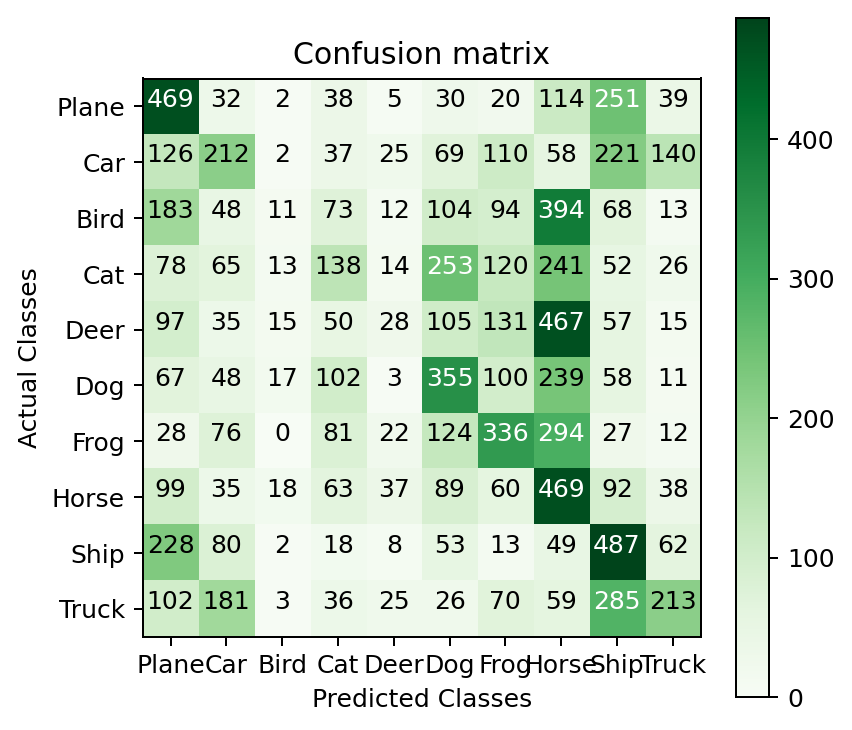

In [64]:
plt.figure(figsize = (5,5), dpi = 180)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()

plt.show()

In [ ]:
# What does our confusion matrix tell us?
# If our model were great, where should we see the biggest numbers/darkest colours?
# Where are the confusions? What classes are being mistaken for which other classes?